In [91]:
import pandas as pd
import numpy as np
import time

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from sklearn import linear_model, svm
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold,\
    StratifiedShuffleSplit, cross_val_score

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,\
    roc_auc_score, roc_curve, classification_report


import xgboost as xgb
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import eli5

import graphviz
from IPython.display import Image
import pydotplus

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

pd.set_option('display.max_columns',99)
pd.set_option('display.max_rows',300)

### Import and Processes Datasets

In [108]:
#READ CSVs

#15,20,25,30 whole and unique

train_unique_15_orig = pd.read_csv('dataset_diabetes/experiment/new/standardized splits/15/unique_train_cleaned_15.csv')
train_whole_15_orig = pd.read_csv('dataset_diabetes/experiment/new/standardized splits/15/whole_train_cleaned_15.csv')
test_unique_15_orig = pd.read_csv('dataset_diabetes/experiment/new/standardized splits/15/unique_test_cleaned_15.csv')

train_unique_20_orig = pd.read_csv('dataset_diabetes/experiment/new/standardized splits/20/unique_train_cleaned_20.csv')
train_whole_20_orig = pd.read_csv('dataset_diabetes/experiment/new/standardized splits/20/whole_train_cleaned_20.csv')
test_unique_20_orig = pd.read_csv('dataset_diabetes/experiment/new/standardized splits/20/unique_test_cleaned_20.csv')

train_unique_25_orig = pd.read_csv('dataset_diabetes/experiment/new/standardized splits/25/unique_train_cleaned_25.csv')
train_whole_25_orig = pd.read_csv('dataset_diabetes/experiment/new/standardized splits/25/whole_train_cleaned_25.csv')
test_unique_25_orig = pd.read_csv('dataset_diabetes/experiment/new/standardized splits/25/unique_test_cleaned_25.csv')

train_unique_30_orig = pd.read_csv('dataset_diabetes/experiment/new/standardized splits/30/unique_train_cleaned_30.csv')
train_whole_30_orig = pd.read_csv('dataset_diabetes/experiment/new/standardized splits/30/whole_train_cleaned_30.csv')
test_unique_30_orig = pd.read_csv('dataset_diabetes/experiment/new/standardized splits/30/unique_test_cleaned_30.csv')

In [189]:
#make copies. #Re-Run this cell to reset version and split selections.

train_unique_15 = train_unique_15_orig.copy()
test_unique_15 = test_unique_15_orig.copy()
train_whole_15 = train_whole_15_orig.copy()

train_unique_20 = train_unique_20_orig.copy()
test_unique_20 = test_unique_20_orig.copy()
train_whole_20 = train_whole_20_orig.copy()

train_unique_25 = train_unique_25_orig.copy()
test_unique_25 = test_unique_25_orig.copy()
train_whole_25 = train_whole_25_orig.copy()

train_unique_30 = train_unique_30_orig.copy()
test_unique_30 = test_unique_30_orig.copy()
train_whole_30 = train_whole_30_orig.copy()

In [95]:
def print_report(y_actual, y_pred, y_pred_proba):
    tn, fp, fn, tp = confusion_matrix(y_actual, y_pred).ravel()
    fpr = fp/(fp+tn)
    auc = roc_auc_score(y_actual, y_pred_proba)
    print('AUC:%.3f'%auc)
    print(f'False positive rate is {fpr}')
    print('tp',tp,'fp',fp,'fn',fn,'tn',tn)

In [190]:
#prepare dfs for model input. #Re-Run this cell to reset version and split selections.
def prep_dfs(split,train_unique,train_whole,test_unique):
    
    train_unique_y = train_unique['readmitted']
    unique_encounter_patient = train_unique[['encounter_id','patient_nbr']]
    train_unique.drop(['readmitted','encounter_id','patient_nbr'], inplace = True, axis = 1)
    
    train_whole_y = train_whole['readmitted']
    whole_encounter_patient = train_whole[['encounter_id','patient_nbr']]
    train_whole.drop(['readmitted','encounter_id','patient_nbr'], inplace = True, axis = 1)
    
    test_unique_y = test_unique['readmitted']
    test_unique.drop(['readmitted','encounter_id','patient_nbr'], inplace = True, axis = 1)
    
    print('{split} percent X_train_unique shape is {shape}'.format(split = split, shape = train_unique.shape))
    print('{split} percent y_train_unique shape is {shape}'.format(split = split, shape = train_unique_y.shape))
    print('{split} percent X_train_whole shape is {shape}'.format(split = split, shape = train_whole.shape))
    print('{split} percent y_train_whole shape is {shape}'.format(split = split, shape = train_whole_y.shape))
    print('{split} percent X_test_unique shape is {shape}'.format(split = split, shape = test_unique.shape))
    print('{split} percent y_test_unique shape is {shape}'.format(split = split, shape = test_unique_y.shape))
    print(' ')
    
    #appy SMOTE
#     smt = SMOTE()
#     train_unique, train_unique_y = smt.fit_sample(train_unique, train_unique_y)
#     train_whole, train_whole_y = smt.fit_sample(train_whole, train_whole_y)

# #     nr = NearMiss()
# #     X_nearmissW, y_nearmissW = nr.fit_sample(X_trainW, y_trainW)
# #     X_nearmissU, y_nearmissU = nr.fit_sample(X_trainU, y_trainU)

#     print('The number of observations in WHOLE_train for each class using SMOTE is now {}'.format(np.bincount(train_whole_y)))
#     print('The number of observations in UNIQUE_train for each class using SMOTE is now {}'.format(np.bincount(train_unique_y)))
    #print('The number of observations in the WHOLE dataset for each class using Near Miss are now {}'.format(np.bincount(y_nearmissW)))
    #print('The number of observations in the UNIQUE dataset for each class using Near Miss are now {}'.format(np.bincount(y_nearmissU)))
    print(' ')
    
    return train_unique, train_unique_y, unique_encounter_patient, train_whole, train_whole_y,\
        whole_encounter_patient,test_unique,test_unique_y

In [191]:
#create dataframes for models. #Re-Run this cell to reset version and split selections.
X_train_unique_15, y_train_unique_15, unique_15_encounter_patient, X_train_whole_15,\
y_train_whole_15, whole_15_encounter_patient,X_test_unique_15,y_test_unique_15 = prep_dfs(15,train_unique_15,\
                                                                       train_whole_15,\
                                                                       test_unique_15)

X_train_unique_20, y_train_unique_20, unique_20_encounter_patient, X_train_whole_20,\
y_train_whole_20, whole_20_encounter_patient,X_test_unique_20,y_test_unique_20 = prep_dfs(20,train_unique_20,\
                                                                       train_whole_20,\
                                                                       test_unique_20)

X_train_unique_25, y_train_unique_25, unique_25_encounter_patient, X_train_whole_25,\
y_train_whole_25, whole_25_encounter_patient,X_test_unique_25,y_test_unique_25 = prep_dfs(25,train_unique_25,\
                                                                        train_whole_25,\
                                                                        test_unique_25)

X_train_unique_30, y_train_unique_30, unique_30_encounter_patient, X_train_whole_30,\
y_train_whole_30, whole_30_encounter_patient,X_test_unique_30,y_test_unique_30 = prep_dfs(30,train_unique_30,\
                                                                       train_whole_30,\
                                                                       test_unique_30)

15 percent X_train_unique shape is (61674, 91)
15 percent y_train_unique shape is (61674,)
15 percent X_train_whole shape is (84422, 91)
15 percent y_train_whole shape is (84422,)
15 percent X_test_unique shape is (13835, 91)
15 percent y_test_unique shape is (13835,)
 
 
20 percent X_train_unique shape is (58793, 91)
20 percent y_train_unique shape is (58793,)
20 percent X_train_whole shape is (79456, 91)
20 percent y_train_whole shape is (79456,)
20 percent X_test_unique shape is (18019, 91)
20 percent y_test_unique shape is (18019,)
 
 
25 percent X_train_unique shape is (55815, 91)
25 percent y_train_unique shape is (55815,)
25 percent X_train_whole shape is (74490, 91)
25 percent y_train_whole shape is (74490,)
25 percent X_test_unique shape is (22049, 91)
25 percent y_test_unique shape is (22049,)
 
 
30 percent X_train_unique shape is (52825, 91)
30 percent y_train_unique shape is (52825,)
30 percent X_train_whole shape is (69524, 91)
30 percent y_train_whole shape is (69524,)
3

In [192]:
#dictionary to store all the different dataframes with different splits.

#Re-Run this cell to reset version and split selections.

versions = {'X_train':{'15w':X_train_whole_15,'15u':X_train_unique_15,\
                       '20w':X_train_whole_20,'20u':X_train_unique_20,\
                       '25w':X_train_whole_25,'25u':X_train_unique_25,\
                       '30w':X_train_whole_30,'30u':X_train_unique_30},\
            'y_train':{'15w':y_train_whole_15,'15u':y_train_unique_15,\
                       '20w':y_train_whole_20,'20u':y_train_unique_20,\
                       '25w':y_train_whole_25,'25u':y_train_unique_25,\
                       '30w':y_train_whole_30,'30u':y_train_unique_30},
            'X_test':{ '15u':X_test_unique_15,\
                       '20u':X_test_unique_20,\
                       '25u':X_test_unique_25,\
                       '30u':X_test_unique_30},\
            'y_test':{ '15u':y_test_unique_15,\
                       '20u':y_test_unique_20,\
                       '25u':y_test_unique_25,\
                       '30u':y_test_unique_30}}

In [193]:
#declare which version to run in model below:

def choose_version(data_split,selection):

    X_train = versions['X_train'][str(data_split)+selection] 
    y_train = versions['y_train'][str(data_split)+selection]
    X_test = versions['X_test'][str(data_split)+'u']
    y_test = versions['y_test'][str(data_split)+'u']
    
    return X_train, y_train, X_test, y_test

In [194]:
def apply_smote(X_train,y_train):
    
    smt = SMOTE()
    X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train, y_train)
    
    print('The number of observations for each class using SMOTE is now {}'.format(np.bincount(y_train_SMOTE)))
    return X_train_SMOTE, y_train_SMOTE

### ==========SELECT SPLIT and VERSION, and SMOTE==========

In [197]:
#++++++++++++++++RUN THIS CELL TO SET WHICH SPLIT VERSION:++++++++++++++++++++

X_train, y_train, X_test, y_test = choose_version(30,'w')

# X_train, y_train, X_test, y_test = choose_version(25,'u')
# X_train, y_train, X_test, y_test = choose_version(30,'w')

#++++++++++++++++RUN THIS CELL TO SET WHICH SPLIT VERSION:++++++++++++++++++++

In [196]:
####################################
###ONLY RUN IF APPLYING SMOTE!!#####
####################################
X_train_SMOTE, y_train_SMOTE = apply_smote(X_train,y_train)


The number of observations for each class using SMOTE is now [61608 61608]


### =====================================================

## MODELING 
**(Logistic Regression, Decision Tree, Random Forest, XGBoost, LightGBM)**

### Logistic Regression

In [45]:
logreg = LogisticRegression(fit_intercept=True, penalty='l2')
logreg.fit(X_train, y_train)
y_test_predict = logreg.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Predict,0,1,All
Actual,,,
0,23388,31,23419
1,2460,23,2483
All,25848,54,25902


In [46]:
# Print Classification Report
report=classification_report(y_test, y_test_predict)
print(report)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     23419
           1       0.43      0.01      0.02      2483

    accuracy                           0.90     25902
   macro avg       0.67      0.50      0.48     25902
weighted avg       0.86      0.90      0.86     25902



In [47]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

23388 31 2460 23


In [48]:
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.904
Precision is 0.426
Recall is 0.009
AUC is 0.504
TPR is 0.009
FPR is 0.001
TNR is 0.999


In [49]:
accuracy_logreg = accuracy_score(y_test, y_test_predict)
precision_logreg = precision_score(y_test, y_test_predict)
recall_logreg = recall_score(y_test, y_test_predict)
auc_logreg = roc_auc_score(y_test, y_test_predict)
TPR_logreg=TPR
FPR_logreg=FPR
TNR_logreg=TNR

In [50]:
coef_base=pd.DataFrame(zip(X_train.columns, np.transpose(logreg.coef_)),columns=['Features','Coefficients']).sort_values(by='Coefficients',ascending=False)

In [51]:
coef_base.head(10)

,Features,Coefficients
7,number_inpatient,[0.33880257199498715]
21,discharge_disposition_id_hospital,[0.32722785908542984]
90,diabetesMed_Yes,[0.18803126962425498]
12,race_Caucasian,[0.07411833848672128]
39,A1Cresult_None,[0.0666841536369386]
6,number_emergency,[0.04682704578098904]
16,gender_Male,[0.04606194535600346]
24,admission_source_id_referral,[0.03512215444557102]
8,number_diagnoses,[0.0328259855267223]
9,med_dosage_change,[0.03157620894184903]


#### Apply SMOTE

In [53]:
# Run the crossvalidation following by fit the SMOTE balanced data

logreg = LogisticRegression(solver = 'liblinear',fit_intercept=True, penalty='l1')
logreg.fit(X_train_SMOTE, y_train_SMOTE)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
# Check with the validation testset
y_test_predict = logreg.predict(X_test)
probability = logreg.predict_proba(X_test)

In [55]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,21782,1637,23419
1,2233,250,2483
All,24015,1887,25902


In [56]:
report=classification_report(y_test, y_test_predict)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     23419
           1       0.13      0.10      0.11      2483

    accuracy                           0.85     25902
   macro avg       0.52      0.52      0.52     25902
weighted avg       0.83      0.85      0.84     25902



In [57]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

21782 1637 2233 250


In [58]:
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.851
Precision is 0.132
Recall is 0.101
AUC is 0.515
TPR is 0.101
FPR is 0.070
TNR is 0.930


In [59]:
accuracy_logreg = accuracy_score(y_test, y_test_predict)
precision_logreg = precision_score(y_test, y_test_predict)
recall_logreg = recall_score(y_test, y_test_predict)
auc_logreg = roc_auc_score(y_test, y_test_predict)
TPR_logreg=TPR
FPR_logreg=FPR
TNR_logreg=TNR

#### Apply 'Class_weight' = balanced

In [81]:
logreg = LogisticRegression(solver = 'liblinear',fit_intercept=True, penalty='l1',class_weight='balanced')
logreg.fit(X_train_SMOTE, y_train_SMOTE)

//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [82]:
# Check with the validation testset
y_test_predict = logreg.predict(X_test)
probability = logreg.predict_proba(X_test)

In [83]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,23026,393,23419
1,2394,89,2483
All,25420,482,25902


In [84]:
report=classification_report(y_test, y_test_predict)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     23419
           1       0.18      0.04      0.06      2483

    accuracy                           0.89     25902
   macro avg       0.55      0.51      0.50     25902
weighted avg       0.84      0.89      0.86     25902



In [85]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

23026 393 2394 89


In [86]:
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.892
Precision is 0.185
Recall is 0.036
AUC is 0.510
TPR is 0.036
FPR is 0.017
TNR is 0.983


In [87]:
accuracy_logreg = accuracy_score(y_test, y_test_predict)
precision_logreg = precision_score(y_test, y_test_predict)
recall_logreg = recall_score(y_test, y_test_predict)
auc_logreg = roc_auc_score(y_test, y_test_predict)
TPR_logreg=TPR
FPR_logreg=FPR
TNR_logreg=TNR

In [88]:
coef_SMOTE=pd.DataFrame(zip(X_train_SMOTE.columns, np.transpose(logreg.coef_)),columns=['Features','Coefficients']).sort_values(by='Coefficients',ascending=False)

In [89]:
coef_SMOTE.head(10)

,Features,Coefficients
73,miglitol_No,[12.612067465145737]
50,chlorpropamide_No,[8.874022604536504]
72,acarbose_Up,[8.093437016023357]
46,repaglinide_Up,[1.8473117936084118]
69,rosiglitazone_Up,[1.0004283727986996]
70,acarbose_No,[0.9108835307350516]
71,acarbose_Steady,[0.8558941537695953]
66,pioglitazone_Up,[0.30507003602892735]
7,number_inpatient,[0.28473241529932924]
89,change_No,[0.04135722767001984]


#### Apply RandomizedSearch

In [70]:
# Apply randomizedsearch to find the optimum "C"

from scipy.stats import uniform

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X_train_SMOTE, y_train_SMOTE)
search.best_params_


{'C': 1.5337660753031108, 'penalty': 'l2'}

In [72]:
logreg = LogisticRegression(solver = 'liblinear',fit_intercept=True, penalty='l1',class_weight='balanced',C=2.195254015709299)
logreg.fit(X_train_SMOTE, y_train_SMOTE)

LogisticRegression(C=2.195254015709299, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
# Check with the validation testset
y_test_predict = logreg.predict(X_test)
probability = logreg.predict_proba(X_test)

In [74]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,23017,402,23419
1,2393,90,2483
All,25410,492,25902


In [75]:
report=classification_report(y_test, y_test_predict)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     23419
           1       0.18      0.04      0.06      2483

    accuracy                           0.89     25902
   macro avg       0.54      0.51      0.50     25902
weighted avg       0.84      0.89      0.86     25902



In [76]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

23017 402 2393 90


In [77]:
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.892
Precision is 0.183
Recall is 0.036
AUC is 0.510
TPR is 0.036
FPR is 0.017
TNR is 0.983


In [78]:
accuracy_logreg = accuracy_score(y_test, y_test_predict)
precision_logreg = precision_score(y_test, y_test_predict)
recall_logreg = recall_score(y_test, y_test_predict)
auc_logreg = roc_auc_score(y_test, y_test_predict)
TPR_logreg=TPR
FPR_logreg=FPR
TNR_logreg=TNR

In [79]:
coef_random_search=pd.DataFrame(zip(X_train_SMOTE.columns, np.transpose(logreg.coef_)),columns=['Features','Coefficients']).sort_values(by='Coefficients',ascending=False)

In [80]:
coef_random_search.head(10)

,Features,Coefficients
73,miglitol_No,[15.824416617697262]
50,chlorpropamide_No,[13.706978642666899]
74,miglitol_Steady,[13.127031310774013]
72,acarbose_Up,[11.820510723576929]
51,chlorpropamide_Steady,[9.841656089281962]
70,acarbose_No,[3.8658115896160767]
71,acarbose_Steady,[2.376770802139911]
46,repaglinide_Up,[2.068448597894659]
10,number_of_medicine,[1.30828573234944]
69,rosiglitazone_Up,[1.0634572858469826]


### Decision Tree Clssifier - "Entropy"

In [13]:
dt_en = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dt_en.fit(X_train_SMOTE, y_train_SMOTE)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=28, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [14]:
y_test_predict = dt_en.predict(X_test)

In [15]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,21285,2134,23419
1,2169,314,2483
All,23454,2448,25902


In [16]:
report=classification_report(y_test, y_test_predict)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     23419
           1       0.13      0.13      0.13      2483

    accuracy                           0.83     25902
   macro avg       0.52      0.52      0.52     25902
weighted avg       0.83      0.83      0.83     25902



In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

21285 2134 2169 314


In [18]:
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.834
Precision is 0.128
Recall is 0.126
AUC is 0.518
TPR is 0.126
FPR is 0.091
TNR is 0.909


In [19]:
accuracy_dt_en = accuracy_score(y_test, y_test_predict)
precision_dt_en = precision_score(y_test, y_test_predict)
recall_dt_en = recall_score(y_test, y_test_predict)
auc_dt_en = roc_auc_score(y_test, y_test_predict)
TPR_dt_en=TPR
FPR_ldt_en=FPR
TNR_dt_en=TNR

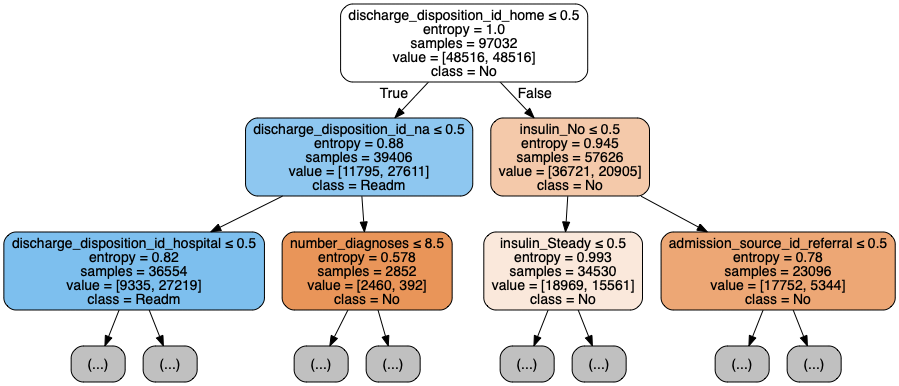

In [20]:
dot_dt_q2 = tree.export_graphviz(dt_en, out_file="dt_q2.dot", feature_names=X_train.columns, max_depth=2,
                                 class_names=["No","Readm"], filled=True, rounded=True, special_characters=True)
graph_dt_q2 = pydotplus.graph_from_dot_file('dt_q2.dot')
Image(graph_dt_q2.create_png())

                          Feature  Importance
1                time_in_hospital    0.026676
0                             age    0.027649
79                     insulin_No    0.034054
22    discharge_disposition_id_na    0.034786
4                 num_medications    0.039329
25   admission_source_id_transfer    0.040827
80                 insulin_Steady    0.050906
2              num_lab_procedures    0.059070
20  discharge_disposition_id_home    0.088871
9               med_dosage_change    0.146836


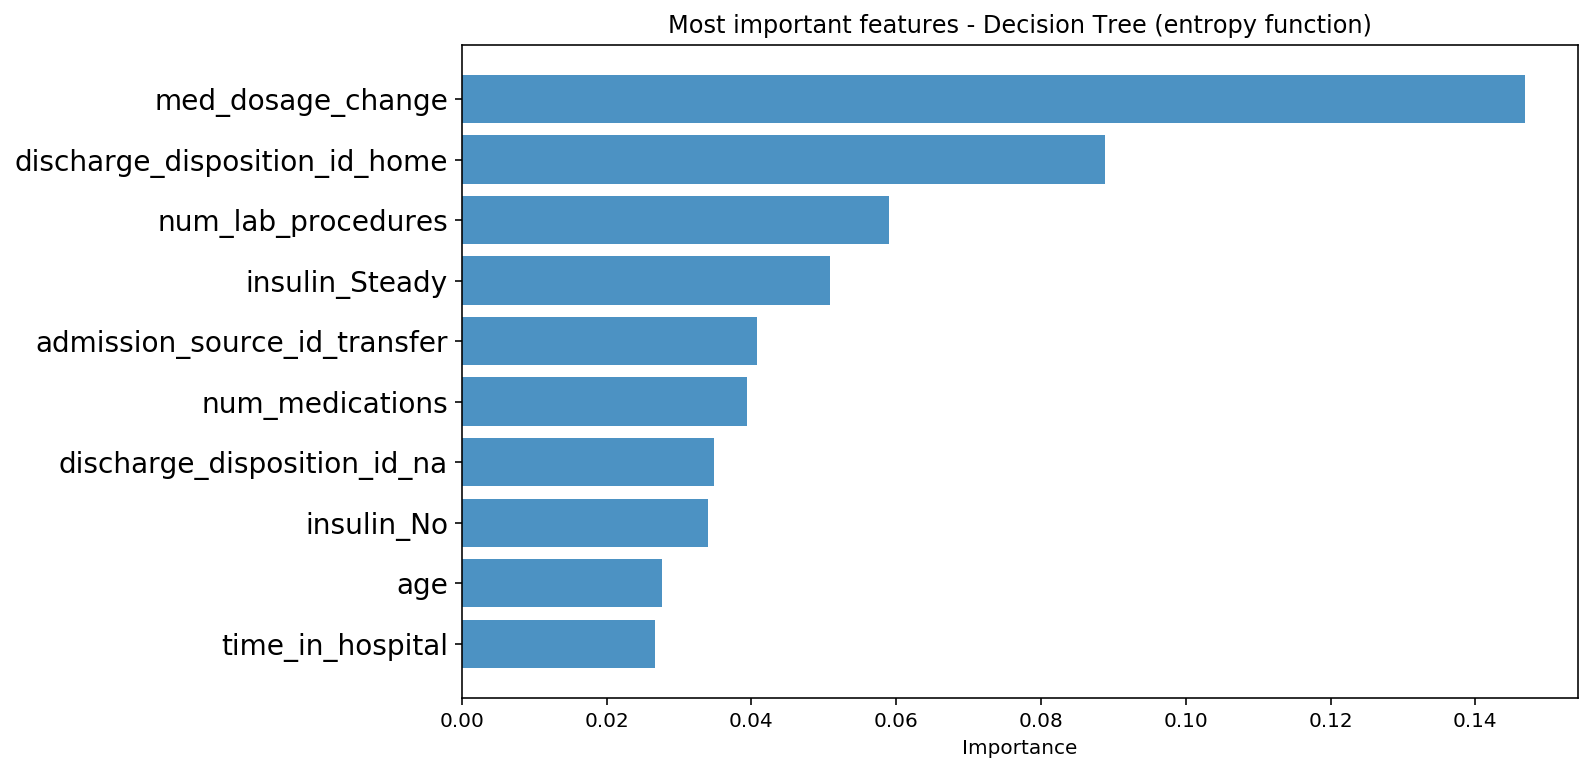

In [21]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = dt_en.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree (entropy function)')
plt.show()

### Random Forest Classifier : "Gini"

In [24]:
rf_gini = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rf_gini.fit(X_train_SMOTE, y_train_SMOTE)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
y_test_predict = rf_gini.predict(X_test)

pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,22962,457,23419
1,2397,86,2483
All,25359,543,25902


In [26]:
report=classification_report(y_test, y_test_predict)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     23419
           1       0.16      0.03      0.06      2483

    accuracy                           0.89     25902
   macro avg       0.53      0.51      0.50     25902
weighted avg       0.83      0.89      0.86     25902



In [27]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

22962 457 2397 86


In [28]:
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.890
Precision is 0.158
Recall is 0.035
AUC is 0.508
TPR is 0.035
FPR is 0.020
TNR is 0.980


In [29]:
accuracy_rf_g = accuracy_score(y_test, y_test_predict)
precision_rf_g = precision_score(y_test, y_test_predict)
recall_rf_g = recall_score(y_test, y_test_predict)
auc_rf_g = roc_auc_score(y_test, y_test_predict)

TPR_rf_g=TPR
FPR_rf_g=FPR
TNR_rf_g=TNR

                          Feature  Importance
1                time_in_hospital    0.026676
0                             age    0.027649
79                     insulin_No    0.034054
22    discharge_disposition_id_na    0.034786
4                 num_medications    0.039329
25   admission_source_id_transfer    0.040827
80                 insulin_Steady    0.050906
2              num_lab_procedures    0.059070
20  discharge_disposition_id_home    0.088871
9               med_dosage_change    0.146836


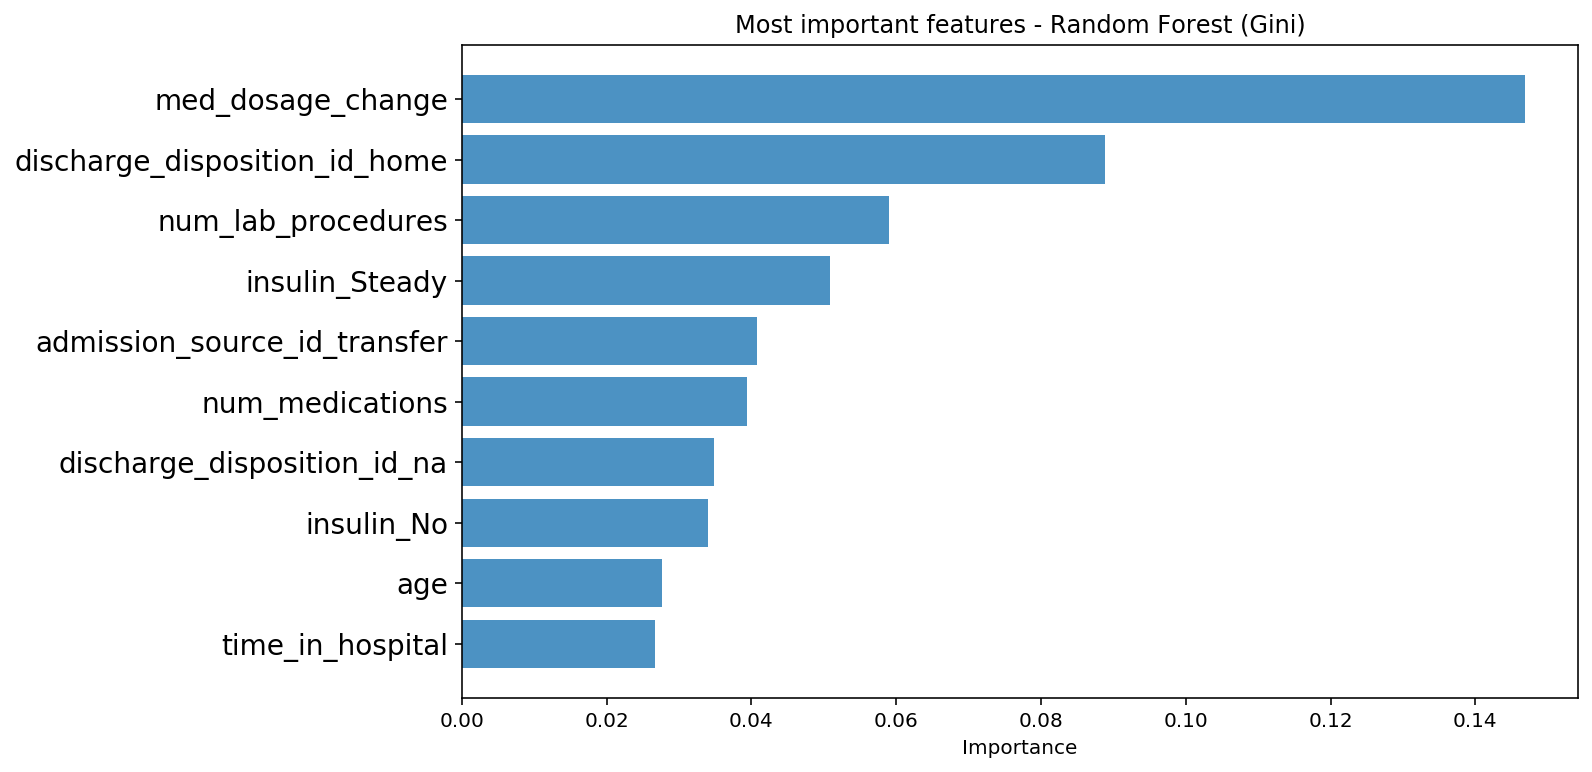

In [32]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = dt_en.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (Gini)')
plt.show()

### Random Forest Classifier : "Entropy"

In [34]:
rf_en = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "entropy", min_samples_split=10)
rf_en.fit(X_train_SMOTE, y_train_SMOTE)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
y_test_predict = rf_en.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,22945,474,23419
1,2403,80,2483
All,25348,554,25902


In [36]:
report=classification_report(y_test, y_test_predict)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     23419
           1       0.14      0.03      0.05      2483

    accuracy                           0.89     25902
   macro avg       0.52      0.51      0.50     25902
weighted avg       0.83      0.89      0.86     25902



In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

22945 474 2403 80


In [38]:
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.889
Precision is 0.144
Recall is 0.032
AUC is 0.506
TPR is 0.032
FPR is 0.020
TNR is 0.980


In [39]:
accuracy_rf_en = accuracy_score(y_test, y_test_predict)
precision_rf_en = precision_score(y_test, y_test_predict)
recall_rf_en = recall_score(y_test, y_test_predict)
auc_rf_en = roc_auc_score(y_test, y_test_predict)

TPR_rf_en=TPR
FPR_rf_en=FPR
TNR_rf_en=TNR

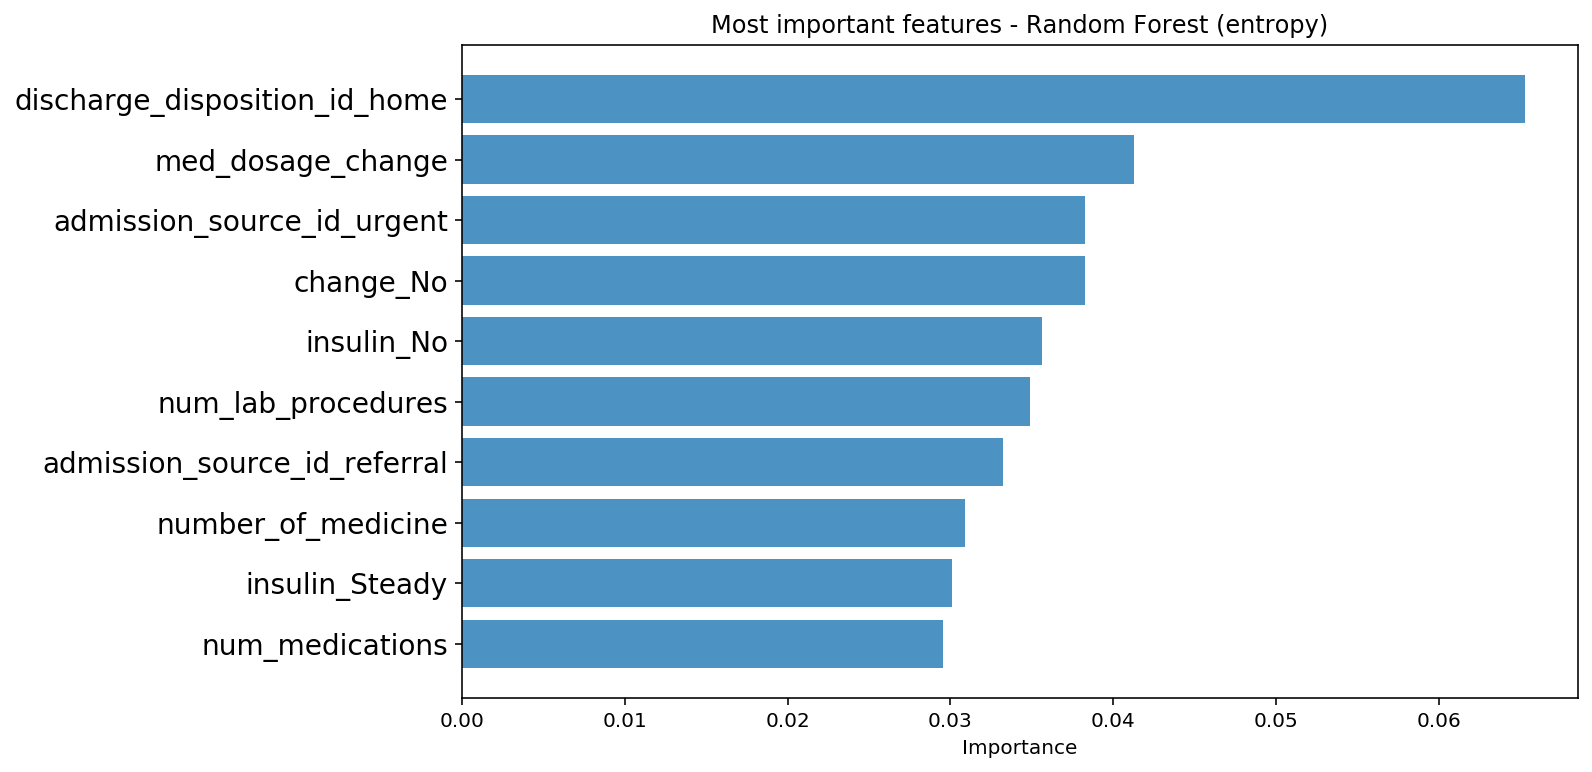

In [40]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = rf_en.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (entropy)')
plt.show()

### XGBoost

In [92]:

xgbc = xgb.XGBClassifier()

In [93]:
#fit X_train, y_train
xgbc.fit(X_train_SMOTE,y_train_SMOTE)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [106]:
thresh=0.5
y_train_pred_proba = xgbc.predict_proba(X_train_SMOTE)[:,1]
y_test_pred_proba = xgbc.predict_proba(X_test)[:,1]

y_train_pred = xgbc.predict(X_train_SMOTE)
y_test_pred = xgbc.predict(X_test)

print('XGBoost')
print('Training:')
print_report(y_train_SMOTE, y_train_pred, y_train_pred_proba)
# print('Validation:')
# print_report(y_valid, y_valid_pred, y_valid_pred_proba)
print('')
print('Test:')
print_report(y_test, y_test_pred, y_test_pred_proba)

XGBoost
Training:
AUC:0.959
False positive rate is 0.022054579932393438
tp 42026 fp 1070 fn 6490 tn 47446

Test:
AUC:0.583
False positive rate is 0.0233571032067979
tp 86 fp 547 fn 2397 tn 22872


In [98]:
sorted(zip(X_train_SMOTE.columns,xgbc.feature_importances_), key= lambda t:t[1], reverse=True)

[('discharge_disposition_id_home', 0.06865046),
 ('discharge_disposition_id_na', 0.06325398),
 ('insulin_Steady', 0.058583777),
 ('admission_source_id_referral', 0.056558333),
 ('med_dosage_change', 0.04428207),
 ('insulin_No', 0.038631003),
 ('gender_Male', 0.037837487),
 ('change_No', 0.036558386),
 ('A1Cresult_Norm', 0.03480518),
 ('metformin_No', 0.03346996),
 ('number_of_medicine', 0.031149613),
 ('diag_1_neoplasms', 0.025729798),
 ('metformin_Steady', 0.025318515),
 ('metformin_Up', 0.024431763),
 ('diag_1_respiratory', 0.024428766),
 ('admission_source_id_urgent', 0.02298124),
 ('glyburide_Steady', 0.020424247),
 ('diag_1_digestive', 0.018801715),
 ('admission_source_id_transfer', 0.017541345),
 ('diag_1_other', 0.01669909),
 ('glyburide_No', 0.016622087),
 ('diabetesMed_Yes', 0.016253175),
 ('glipizide_No', 0.01624317),
 ('diag_1_injury', 0.015683798),
 ('rosiglitazone_Steady', 0.015552843),
 ('admission_source_id_other', 0.014344405),
 ('diag_1_genitourinary', 0.01396931),
 ('

### **parameter tuning**

In [116]:
xgbc1 = xgb.XGBClassifier()
xgbc1.set_params(learning_rate=0.1,subsample=0.8,n_estimators=3000,max_depth=6,
                colsample_bytree=1,objective='binary:logistic', n_jobs = -1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=3000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [119]:
#fit X_train, y_train
xgbc1.fit(X_train_SMOTE,y_train_SMOTE)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=3000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [120]:
xgbc1.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=3000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)>

In [121]:
y_train_pred_proba = xgbc1.predict_proba(X_train_SMOTE)[:,1]
# y_valid_pred_proba = xgbc1.predict_proba(X_valid)[:,1]
y_test_pred_proba = xgbc1.predict_proba(X_test)[:,1]

y_train_pred = xgbc1.predict(X_train_SMOTE)
# y_valid_pred = xgbc1.predict(X_valid)
y_test_pred = xgbc1.predict(X_test)

print('Tuned XGBoost')
print('Training:')
print_report(y_train_SMOTE, y_train_pred, y_train_pred_proba)
# print('Validation:')
# print_report(y_valid, y_valid_pred, y_valid_pred_proba)
print('Test:')
print_report(y_test, y_test_pred, y_test_pred_proba)

Tuned XGBoost
Training:
AUC:1.000
False positive rate is 0.0
tp 48198 fp 0 fn 318 tn 48516
Test:
AUC:0.597
False positive rate is 0.013493317391861308
tp 92 fp 316 fn 2391 tn 23103


In [122]:
confusion_matrix(y_train_SMOTE, y_train_pred)

array([[48516,     0],
       [  318, 48198]])

In [123]:
confusion_matrix(y_test, y_test_pred)

array([[23103,   316],
       [ 2391,    92]])

In [124]:
sorted(zip(X_train_SMOTE.columns,xgbc1.feature_importances_), key= lambda t:t[1], reverse=True)

[('number_inpatient', 0.08107234),
 ('discharge_disposition_id_na', 0.05826725),
 ('age', 0.04582175),
 ('discharge_disposition_id_home', 0.035013717),
 ('time_in_hospital', 0.029727338),
 ('num_procedures', 0.028657882),
 ('admission_source_id_other', 0.027098417),
 ('number_diagnoses', 0.027074175),
 ('glimepiride_Up', 0.021458054),
 ('pioglitazone_Up', 0.021281218),
 ('diag_1_musculoskeletal', 0.018528832),
 ('discharge_disposition_id_hospital', 0.018377714),
 ('diag_1_injury', 0.01791696),
 ('diag_1_other', 0.017804991),
 ('pioglitazone_No', 0.016928274),
 ('diag_1_respiratory', 0.016618246),
 ('diag_1_neoplasms', 0.016503366),
 ('A1Cresult_Norm', 0.016462425),
 ('diag_1_genitourinary', 0.016287988),
 ('admission_source_id_transfer', 0.01624586),
 ('diag_1_digestive', 0.016087407),
 ('number_outpatient', 0.015034139),
 ('number_emergency', 0.014934114),
 ('diag_1_diabetes', 0.014502593),
 ('glimepiride_No', 0.0132028395),
 ('med_dosage_change', 0.012663198),
 ('number_of_medicine',

In [125]:
eli5.show_weights(xgbc1)

Weight,Feature
0.0811,number_inpatient
0.0583,discharge_disposition_id_na
0.0458,age
0.0350,discharge_disposition_id_home
0.0297,time_in_hospital
0.0287,num_procedures
0.0271,admission_source_id_other
0.0271,number_diagnoses
0.0215,glimepiride_Up
0.0213,pioglitazone_Up


In [126]:
# X_test['predicted_probaility'] = y_test_pred_proba
# X_test['actual_readmitted'] = y_test
# X_test['predicted_readmitted'] = y_test_pred

In [127]:
X_test.sort_values(by='predicted_probaility')

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,med_dosage_change,number_of_medicine,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_unknown,gender_Male,admission_type_id_na,admission_type_id_newborn,admission_type_id_urgent,discharge_disposition_id_home,discharge_disposition_id_hospital,discharge_disposition_id_na,admission_source_id_other,admission_source_id_referral,admission_source_id_transfer,admission_source_id_urgent,diag_1_diabetes,diag_1_digestive,diag_1_genitourinary,diag_1_injury,diag_1_musculoskeletal,diag_1_neoplasms,diag_1_other,diag_1_respiratory,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,acetohexamide_Steady,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_Steady,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes,predicted_probaility,actual_readmitted,predicted_readmitted
13542,-1.928080,-0.801560,-2.137087,0.390898,-1.603346,4.450235,-0.211600,-0.500531,0.823365,0,-1.287246,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,4.803877e-08,0,0
16035,-1.928080,-0.801560,0.667612,0.390898,-0.738640,-0.291878,-0.211600,-0.500531,-2.267774,0,-1.287246,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1.823302e-07,0,0
15153,1.207636,-1.138422,-0.556257,-0.783594,-1.356287,-0.291878,-0.211600,-0.500531,-1.752584,0,1.965199,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,9.530851e-07,0,0
5022,-1.300937,-1.138422,-2.137087,0.978144,0.002537,-0.291878,-0.211600,-0.500531,-1.752584,0,-0.203098,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1.188095e-06,0,0
12300,-1.928080,-0.801560,-2.137087,0.978144,-1.479817,9.982699,-0.211600,-0.500531,-0.207015,1,-0.203098,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1.238036e-06,0,0
12049,-3.182366,-1.138422,-1.270180,-0.196348,-0.615110,-0.291878,-0.211600,-0.500531,-2.782964,0,-1.287246,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1.355211e-06,0,0
19950,-1.300937,2.903921,1.483524,2.152636,0.743714,-0.291878,-0.211600,-0.500531,-1.237394,0,-0.203098,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1.383523e-06,0,0
25158,-0.046651,-0.464698,-0.046311,-0.783594,-1.850405,-0.291878,-0.211600,-0.500531,-0.207015,0,-1.287246,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1.388001e-06,0,0
7967,-0.046651,-0.464698,-0.556257,0.3

In [128]:
#adding the quantiles as another columns
# X_test['Quantile_rank'] = pd.qcut(X_test['predicted_probaility'],10,labels=False)

### LightGBM

**Base lightgbm (with SMOTE)**

In [144]:
# del X_test['predicted_probaility']
# del X_test['actual_readmitted']
# del X_test['predicted_readmitted']
# del X_test['Quantile_rank']

In [150]:
lgbbase = lgb.LGBMClassifier()
lgbbase.fit(X_train_SMOTE,y_train_SMOTE)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [151]:
print("")
#print('='*25,'Results','='*25)
print('')
#print("Score best parameters: ", min(loss)*-1)
#print("Best parameters: ", best_param)
#print("Test Score: ", clf_best.score(X_test, y_test))
#print("Time elapsed: ", time.time() - start)
#print("Parameter combinations evaluated: ", num_eval)
auc = roc_auc_score(y_test, lgbbase.predict_proba(X_test)[:,1])
auct = roc_auc_score(y_train_SMOTE, lgbbase.predict_proba(X_train_SMOTE)[:,1])
print('AUC train is: ',auct)
print('AUC test is: ',auc)
print_report(y_test,lgbbase.predict(X_test),lgbbase.predict_proba(X_test)[:,1])
cmlgbb = pd.DataFrame(confusion_matrix(y_test,lgbbase.predict(X_test)))
cmlgbb



AUC train is:  0.9750779364109845
AUC test is:  0.6410071340919095
AUC:0.641
False positive rate is 0.0011102096588240318
tp 14 fp 26 fn 2469 tn 23393


,0,1
0,23393,26
1,2469,14


In [170]:
confusion_matrix(y_train_SMOTE, clf_best.predict(X_train_SMOTE))

array([[54153,    15],
       [ 4643, 49525]])

**Tune LightGBM SMOTE: Bayesian Optimization** 

In [159]:
#declare objective function for the optimizer
def objective_function(params):
    clf = lgb.LGBMClassifier(**params)
    skf = ms.StratifiedKFold(n_splits=10, shuffle=True, random_state=99)
    score = cross_val_score(clf, X_train_SMOTE, y_train_SMOTE, scoring = 'roc_auc', cv=skf, n_jobs=-1)
    return {'loss': 1-score.mean(), 'status': STATUS_OK}

In [166]:
#parameter space and minimizer

num_eval = 100
#params to consider
param_hyperopt= {
                #'is_unbalanced': True,
                'objective':'binary',
                'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.09)),
                'max_depth': scope.int(hp.quniform('max_depth', 25, 80, 1)), #5,19,1
                'min_data_in_leaf':scope.int(hp.quniform('min_data_in_leaf', 50, 60, 5)),
                'n_estimators': scope.int(hp.quniform('n_estimators', 100, 200, 20)), #5,55,1  180,220
                'num_leaves': scope.int(hp.quniform('num_leaves', 100, 160, 1)), #5,50,1
                'boosting_type': 'goss', #hp.choice('boosting_type', ['gbdt','dart','goss']), #check lightgbm for types
                'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
                'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.5), #ridge
                #'drop_rate': hp.uniform('drop_rate', 0.0, 1.0),
                'reg_alpha': hp.uniform('reg_alpha', 0.10, 0.15),
                #'max_bin': scope.int(hp.quniform('max_bin', 255, 265, 1)),
                #'scale_pos_weight': hp.uniform('scale_pos_weight', 1,1.1),
                #'early_stopping_round': scope.int(hp.quniform('early_stopping_round', 100, 101, 1)),
                'metric': 'auc'
                }

#loss minimizer, then store parameters
trials = Trials()
best_param = fmin(objective_function, 
                  param_hyperopt, 
                  algo=tpe.suggest, 
                  max_evals=num_eval, 
                  trials=trials,
                  rstate= np.random.RandomState(1))
loss = [x['result']['loss'] for x in trials.trials]
best_param_values = [x for x in best_param.values()]

  4%|▍         | 4/100 [00:49<19:43, 12.33s/it, best loss: 0.02579240121919424]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  6%|▌         | 6/100 [01:15<20:01, 12.78s/it, best loss: 0.02579240121919424]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 18%|█▊        | 18/100 [04:07<20:01, 14.66s/it, best loss: 0.024798749299005052]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 24%|██▍       | 24/100 [05:45<21:25, 16.91s/it, best loss: 0.024798749299005052]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 27%|██▋       | 27/100 [06:43<22:47, 18.73s/it, best loss: 0.02479821837308316] 

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 30%|███       | 30/100 [07:29<18:49, 16.14s/it, best loss: 0.02479821837308316]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 37%|███▋      | 37/100 [09:14<14:48, 14.10s/it, best loss: 0.02479821837308316]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 52%|█████▏    | 52/100 [13:27<13:54, 17.38s/it, best loss: 0.02460715946748593]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 57%|█████▋    | 57/100 [14:41<11:51, 16.56s/it, best loss: 0.02460715946748593]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 59%|█████▉    | 59/100 [15:08<10:12, 14.93s/it, best loss: 0.02460715946748593]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 75%|███████▌  | 75/100 [19:26<06:57, 16.68s/it, best loss: 0.02460715946748593]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 77%|███████▋  | 77/100 [19:58<06:08, 16.01s/it, best loss: 0.02460715946748593]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 78%|███████▊  | 78/100 [20:12<05:39, 15.43s/it, best loss: 0.02460715946748593]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 80%|████████  | 80/100 [20:46<05:20, 16.00s/it, best loss: 0.02460715946748593]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 81%|████████  | 81/100 [21:00<04:55, 15.55s/it, best loss: 0.02460715946748593]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 84%|████████▍ | 84/100 [21:49<04:18, 16.16s/it, best loss: 0.02441440819406271]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 89%|████████▉ | 89/100 [23:15<03:03, 16.69s/it, best loss: 0.02441440819406271]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 90%|█████████ | 90/100 [23:33<02:48, 16.84s/it, best loss: 0.02441440819406271]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 91%|█████████ | 91/100 [23:48<02:28, 16.49s/it, best loss: 0.02441440819406271]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 94%|█████████▍| 94/100 [24:37<01:39, 16.53s/it, best loss: 0.02441440819406271]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 95%|█████████▌| 95/100 [24:52<01:20, 16.04s/it, best loss: 0.02441440819406271]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 96%|█████████▌| 96/100 [25:12<01:09, 17.33s/it, best loss: 0.02441440819406271]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 99%|█████████▉| 99/100 [26:01<00:17, 17.36s/it, best loss: 0.02441440819406271]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



100%|██████████| 100/100 [26:16<00:00, 16.72s/it, best loss: 0.02441440819406271]


In [167]:
best_param

{'colsample_bytree': 0.5993630445924604,
 'learning_rate': 0.03662754932262396,
 'max_depth': 33.0,
 'min_data_in_leaf': 60.0,
 'n_estimators': 180.0,
 'num_leaves': 155.0,
 'reg_alpha': 0.11835258487700767,
 'reg_lambda': 1.4773724796334375}

In [173]:
#fit based off the optimizer above

if best_param_values[0] == 0:
    boosting_type = 'gbdt'

elif best_param_values[0] == 1:
    boosting_type = 'dart'

else:
    #best_param_values[0] == 2
    boosting_type = 'goss'    
    
# else:
#     boosting_type = 'goss'
        
    
clf_smote = lgb.LGBMClassifier(
                              #is_unbalanced = True,
                              boosting_type=boosting_type,
                              colsample_bytree = best_param['colsample_bytree'],
                              #drop_rate = best_param['drop_rate'],
                              learning_rate = best_param['learning_rate'],
                              #max_bin = int(best_param['max_bin']),
                              min_data_in_leaf = int(best_param['min_data_in_leaf']),
                              max_depth = int(best_param['max_depth']),
                              n_estimators = int(best_param['n_estimators']),
                              num_leaves = int(best_param['num_leaves']),
                              reg_alpha = best_param['reg_alpha'],
                              reg_lambda = best_param['reg_lambda'],
                              objective = 'binary',
                              metric = 'auc',
                              #scale_pos_weight = 1 #best_param['scale_pos_weight'], #4
#                               bagging_frequency = 1,
#                               pos_bagging_fraction = .99,
#                               neg_bagging_fraction = .3
                              
                              #early_stopping_round = int(best_param['early_stopping_round'])
                              )
                                  
clf_smote.fit(X_train_SMOTE, y_train_SMOTE)

LGBMClassifier(boosting_type='goss', class_weight=None,
               colsample_bytree=0.5993630445924604, importance_type='split',
               learning_rate=0.03662754932262396, max_depth=33, metric='auc',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=60, min_split_gain=0.0, n_estimators=180,
               n_jobs=-1, num_leaves=155, objective='binary', random_state=None,
               reg_alpha=0.11835258487700767, reg_lambda=1.4773724796334375,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [174]:
## print("")
print('='*25,'Results','='*25)
print('')
print("Score best parameters: ", min(loss)*-1)
print("Best parameters: ", best_param)
print("Test Score: ", clf_smote.score(X_test, y_test))
#print("Time elapsed: ", time.time() - start)
print("Parameter combinations evaluated: ", num_eval)
auc = roc_auc_score(y_test, clf_smote.predict_proba(X_test)[:,1])
auct = roc_auc_score(y_train, clf_smote.predict_proba(X_train)[:,1])
print('AUC train is: ',auct)
print('AUC test is: ',auc)
print_report(y_test,clf_smote.predict(X_test),clf_smote.predict_proba(X_test)[:,1])
cmlgbm = pd.DataFrame(confusion_matrix(y_test,clf_smote.predict(X_test)))
cmlgbm

========================= Results =========================

Score best parameters:  -0.02441440819406271
Best parameters:  {'colsample_bytree': 0.5993630445924604, 'learning_rate': 0.03662754932262396, 'max_depth': 33.0, 'min_data_in_leaf': 60.0, 'n_estimators': 180.0, 'num_leaves': 155.0, 'reg_alpha': 0.11835258487700767, 'reg_lambda': 1.4773724796334375}
Test Score:  0.8983295410400133
Parameter combinations evaluated:  100
AUC train is:  0.8209795251609607
AUC test is:  0.6370584329259834
AUC:0.637
False positive rate is 0.001421156697973307
tp 26 fp 23 fn 1809 tn 16161


,0,1
0,16161,23
1,1809,26


**Tune LightGBM NO SMOTE: Bayesian Optimization** 

In [183]:
num_eval = 100
#params to consider
param_hyperopt= {
                'is_unbalanced': True,
                'objective':'binary',
                'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.09)),
                'max_depth': scope.int(hp.quniform('max_depth', 25, 80, 1)), #5,19,1
                'min_data_in_leaf':scope.int(hp.quniform('min_data_in_leaf', 50, 60, 5)),
                'n_estimators': scope.int(hp.quniform('n_estimators', 100, 300, 20)), #5,55,1  180,220
                'num_leaves': scope.int(hp.quniform('num_leaves', 100, 160, 1)), #5,50,1
                'boosting_type': 'goss', #hp.choice('boosting_type', ['gbdt','dart','goss']), #check lightgbm for types
                'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
                'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.5), #ridge
                #'drop_rate': hp.uniform('drop_rate', 0.0, 1.0),
                'reg_alpha': hp.uniform('reg_alpha', 0.10, 0.15),
                #'max_bin': scope.int(hp.quniform('max_bin', 255, 265, 1)),
                #'scale_pos_weight': hp.uniform('scale_pos_weight', 1,1.1),
                #'early_stopping_round': scope.int(hp.quniform('early_stopping_round', 100, 101, 1)),
                'metric': 'auc'
                }

#loss minimizer, then store parameters
trials = Trials()
best_param = fmin(objective_function, 
                  param_hyperopt, 
                  algo=tpe.suggest, 
                  max_evals=num_eval, 
                  trials=trials,
                  rstate= np.random.RandomState(1))
loss = [x['result']['loss'] for x in trials.trials]
best_param_values = [x for x in best_param.values()]

  5%|▌         | 5/100 [01:25<27:48, 17.57s/it, best loss: 0.02505641953993898] 

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  6%|▌         | 6/100 [01:48<29:43, 18.98s/it, best loss: 0.02505641953993898]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  7%|▋         | 7/100 [02:02<27:20, 17.64s/it, best loss: 0.02505641953993898]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 24%|██▍       | 24/100 [07:48<28:57, 22.86s/it, best loss: 0.024286866379891414]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 25%|██▌       | 25/100 [08:20<32:09, 25.73s/it, best loss: 0.024286866379891414]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 28%|██▊       | 28/100 [09:33<30:10, 25.14s/it, best loss: 0.024286866379891414]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 29%|██▉       | 29/100 [09:52<27:15, 23.04s/it, best loss: 0.024286866379891414]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 41%|████      | 41/100 [15:03<25:22, 25.80s/it, best loss: 0.024109457282135316]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 43%|████▎     | 43/100 [15:52<23:12, 24.43s/it, best loss: 0.024109457282135316]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 46%|████▌     | 46/100 [16:59<21:04, 23.41s/it, best loss: 0.024109457282135316]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 52%|█████▏    | 52/100 [18:59<15:02, 18.81s/it, best loss: 0.024109457282135316]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 63%|██████▎   | 63/100 [23:12<13:44, 22.29s/it, best loss: 0.024109457282135316]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 73%|███████▎  | 73/100 [27:08<09:28, 21.07s/it, best loss: 0.02387096889309137] 

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 74%|███████▍  | 74/100 [27:23<08:23, 19.37s/it, best loss: 0.02387096889309137]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 82%|████████▏ | 82/100 [29:46<05:14, 17.50s/it, best loss: 0.023863293878196856]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 84%|████████▍ | 84/100 [30:30<05:16, 19.78s/it, best loss: 0.023863293878196856]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 85%|████████▌ | 85/100 [30:45<04:33, 18.24s/it, best loss: 0.023863293878196856]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 87%|████████▋ | 87/100 [31:22<03:59, 18.45s/it, best loss: 0.023863293878196856]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 90%|█████████ | 90/100 [32:22<03:10, 19.01s/it, best loss: 0.023863293878196856]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



100%|██████████| 100/100 [35:54<00:00, 20.20s/it, best loss: 0.023863293878196856]


In [184]:
best_param

{'colsample_bytree': 0.850607965488215,
 'learning_rate': 0.038039462109603905,
 'max_depth': 36.0,
 'min_data_in_leaf': 60.0,
 'n_estimators': 180.0,
 'num_leaves': 157.0,
 'reg_alpha': 0.14076532819001125,
 'reg_lambda': 0.059321342548454004}

In [187]:
if best_param_values[0] == 0:
    boosting_type = 'gbdt'

elif best_param_values[0] == 1:
    boosting_type = 'dart'

else:
    #best_param_values[0] == 2
    boosting_type = 'goss'    
    
# else:
#     boosting_type = 'goss'
        
    
clf_best = lgb.LGBMClassifier(
                              #is_unbalanced = True,
                              boosting_type=boosting_type,
                              colsample_bytree = best_param['colsample_bytree'],
                              #drop_rate = best_param['drop_rate'],
                              learning_rate = best_param['learning_rate'],
                              #max_bin = int(best_param['max_bin']),
                              min_data_in_leaf = int(best_param['min_data_in_leaf']),
                              max_depth = int(best_param['max_depth']),
                              n_estimators = int(best_param['n_estimators']),
                              num_leaves = int(best_param['num_leaves']),
                              reg_alpha = best_param['reg_alpha'],
                              reg_lambda = best_param['reg_lambda'],
                              objective = 'binary',
                              metric = 'auc',
                              scale_pos_weight = 2 #best_param['scale_pos_weight'], #4
#                               bagging_frequency = 1,
#                               pos_bagging_fraction = .99,
#                               neg_bagging_fraction = .3
                              
                              #early_stopping_round = int(best_param['early_stopping_round'])
                              )
                                  
clf_best.fit(X_train, y_train)

LGBMClassifier(boosting_type='goss', class_weight=None,
               colsample_bytree=0.850607965488215, importance_type='split',
               learning_rate=0.038039462109603905, max_depth=36, metric='auc',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=60, min_split_gain=0.0, n_estimators=180,
               n_jobs=-1, num_leaves=157, objective='binary', random_state=None,
               reg_alpha=0.14076532819001125, reg_lambda=0.059321342548454004,
               scale_pos_weight=2, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [188]:
## print("")
print('='*25,'Results','='*25)
print('')
print("Score best parameters: ", min(loss)*-1)
print("Best parameters: ", best_param)
print("Test Score: ", clf_best.score(X_test, y_test))
#print("Time elapsed: ", time.time() - start)
print("Parameter combinations evaluated: ", num_eval)
auc = roc_auc_score(y_test, clf_best.predict_proba(X_test)[:,1])
auct = roc_auc_score(y_train, clf_best.predict_proba(X_train)[:,1])
print('AUC train is: ',auct)
print('AUC test is: ',auc)
print_report(y_test,clf_best.predict(X_test),clf_best.predict_proba(X_test)[:,1])
cmlgbm = pd.DataFrame(confusion_matrix(y_test,clf_best.predict(X_test)))
cmlgbm

========================= Results =========================

Score best parameters:  -0.023863293878196856
Best parameters:  {'colsample_bytree': 0.850607965488215, 'learning_rate': 0.038039462109603905, 'max_depth': 36.0, 'min_data_in_leaf': 60.0, 'n_estimators': 180.0, 'num_leaves': 157.0, 'reg_alpha': 0.14076532819001125, 'reg_lambda': 0.059321342548454004}
Test Score:  0.8928803758583304
Parameter combinations evaluated:  100
AUC train is:  0.9096146980857975
AUC test is:  0.6382515932666132
AUC:0.638
False positive rate is 0.006064036222509703
tp 60 fp 75 fn 1407 tn 12293


,0,1
0,12293,75
1,1407,60


**SELECTED (70% whole train)**

In [198]:
clf_chosen = lgb.LGBMClassifier(
                              is_unbalanced = True,
                              boosting_type='goss',
                              colsample_bytree = 0.5937307464548665,
                              #drop_rate = best_param['drop_rate'],
                              learning_rate = 0.017865274565261144,
                              #max_bin = int(best_param['max_bin']),
                              min_data_in_leaf = 800,
                              max_depth = 61,
                              n_estimators = 3300,
                              num_leaves = 320,
                              reg_alpha = 0.1376473846645497,
                              reg_lambda = 1.3051865999142085,
                              objective = 'binary',
                              metric = 'auc',
                              #scale_pos_weight = best_param['scale_pos_weight'], #4
#                               bagging_frequency = 1,
#                               pos_bagging_fraction = .99,
#                               neg_bagging_fraction = .3
                              
                              #early_stopping_round = int(best_param['early_stopping_round'])
                              )
                                  
clf_chosen.fit(X_train, y_train)

LGBMClassifier(boosting_type='goss', class_weight=None,
               colsample_bytree=0.5937307464548665, importance_type='split',
               is_unbalanced=True, learning_rate=0.017865274565261144,
               max_depth=61, metric='auc', min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=800, min_split_gain=0.0,
               n_estimators=3300, n_jobs=-1, num_leaves=320, objective='binary',
               random_state=None, reg_alpha=0.1376473846645497,
               reg_lambda=1.3051865999142085, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [199]:
## print("")
print('='*25,'Results','='*25)
print('')
print("Score best parameters: ", min(loss)*-1)
#print("Best parameters: ", best_param)
print("Test Score: ", clf_chosen.score(X_test, y_test))
#print("Time elapsed: ", time.time() - start)
print("Parameter combinations evaluated: ", num_eval)
auc = roc_auc_score(y_test, clf_chosen.predict_proba(X_test)[:,1])
auct = roc_auc_score(y_train, clf_chosen.predict_proba(X_train)[:,1])
print('AUC train is: ',auct)
print('AUC test is: ',auc)
print_report(y_test,clf_chosen.predict(X_test),clf_chosen.predict_proba(X_test)[:,1])
cmclgbm = confusion_matrix(y_test,clf_chosen.predict(X_test))
cmclgbm

========================= Results =========================

Score best parameters:  -0.023863293878196856
Test Score:  0.9043703188942939
Parameter combinations evaluated:  100
AUC train is:  0.7496556503739202
AUC test is:  0.648185379526938
AUC:0.648
False positive rate is 0.00012810111447969597
tp 9 fp 3 fn 2474 tn 23416


array([[23416,     3],
       [ 2474,     9]])

In [200]:
chosen_weights = eli5.explain_weights(clf_chosen)
chosen_weights

Weight,Feature
0.1731,number_inpatient
0.1457,num_lab_procedures
0.1052,num_medications
0.0754,time_in_hospital
0.0551,age
0.0541,number_diagnoses
0.0537,discharge_disposition_id_home
0.0453,num_procedures
0.0254,number_emergency
0.0243,number_of_medicine


In [201]:
feat_imp = pd.DataFrame({'weights': [0.174,0.1437,0.1044,0.0756,0.0555,0.0533,0.0532,0.0463,0.025,0.0245,0.0205,0.0177,0.0148,0.0139,0.0128,0.0125,0.012,0.0111,0.011],\
 'features':['Inpatient Visits','Num. lab procedure','Num. .medications','Time in hospital','age','discharged to home','number of diagnoses','Num. procedures','Num. emergency','Num. medicine','Male','discharged to hospital','admitted from urgentcare','No insulin given','Num. outpatient','change_No','med. dosage change','admitted from referral','admission type urgent']})

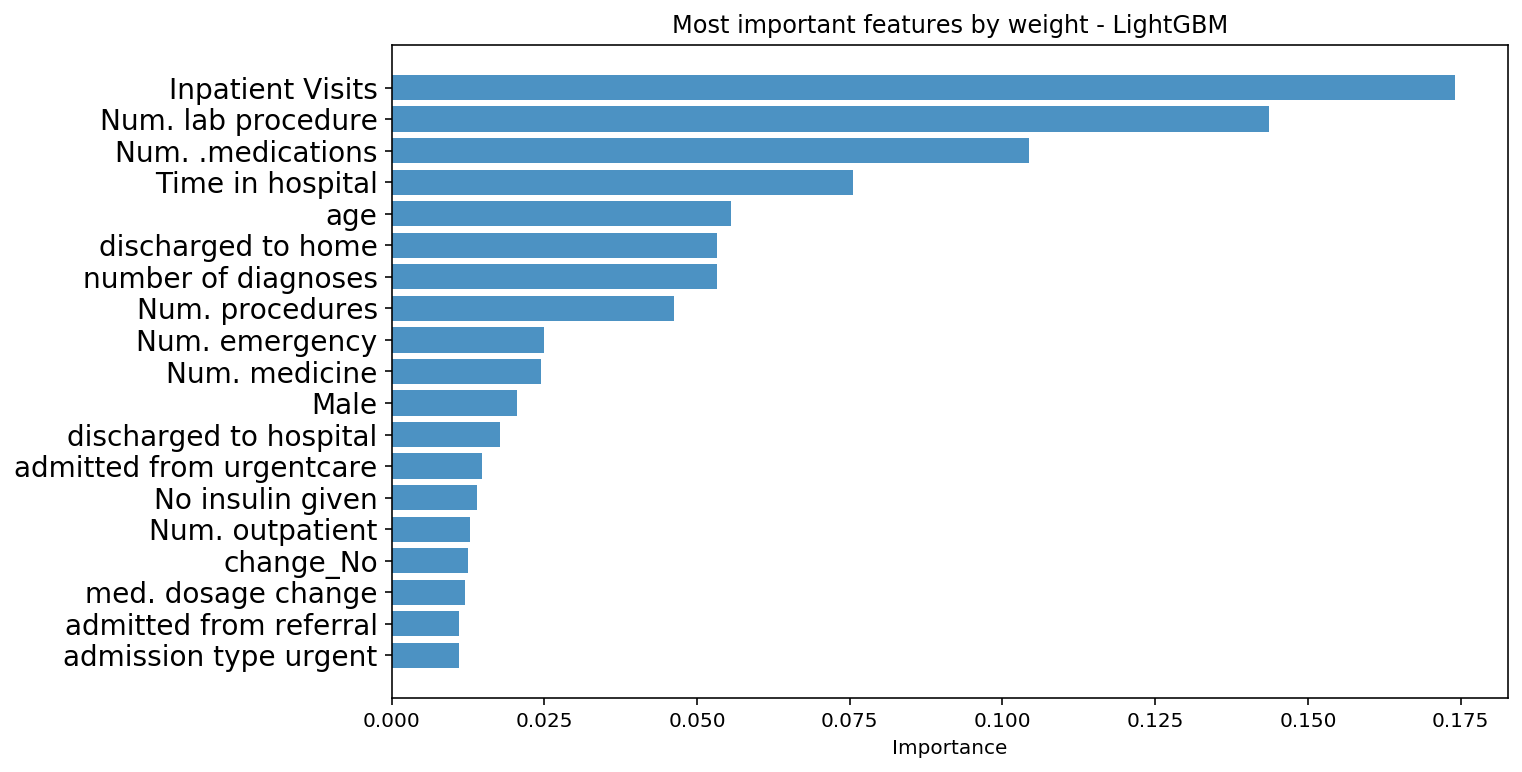

In [202]:
#feature_names = feat_imp['features']
#feature_imports = feat_imp['weights']
#most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
feat_imp.sort_values(by="weights", inplace=True, ascending = True)
plt.figure(figsize=(10,6))
plt.barh(range(len(feat_imp)), feat_imp['weights'], align='center', alpha=0.8)
plt.yticks(range(len(feat_imp)), feat_imp['features'], fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features by weight - LightGBM')
plt.show()

In [203]:
def make_lift(X_test,y_test,best_model):
    
    liftdf = X_test.copy()

    liftdf['predicted_probaility'] = best_model.predict_proba(X_test)[:,1]
    liftdf['predicted_readmitted'] = best_model.predict(X_test)
    liftdf['actual_readmitted'] = y_test
    #adding the quantiles as another columns
    liftdf['Quantile_rank'] = pd.qcut(liftdf['predicted_probaility'],10,labels=np.arange(1,11))
    
    group = liftdf.groupby('Quantile_rank', as_index = False)['actual_readmitted'].agg(['count','sum'])
    group.columns = ['unique patients', 'actual readmitted']
    group.reset_index(inplace = True)
    
    lift_chart = liftdf.groupby('Quantile_rank')['predicted_probaility'].agg(['min','max','mean'])
    lift_chart.columns = ['min_prob','max_prob','avg_prob']
    lift_chart.reset_index(inplace = True)
    
    lift_table = pd.merge(group,lift_chart, how = 'left', on = 'Quantile_rank')
    lift_table['pct_readmitted'] = lift_table['actual readmitted']/lift_table['unique patients']
    
    return lift_table

In [204]:
lift = make_lift(X_test,y_test,clf_chosen)
lift

,Quantile_rank,unique patients,actual readmitted,min_prob,max_prob,avg_prob,pct_readmitted
0,1,2591,82,0.012219,0.040041,0.031444,0.031648
1,2,2590,153,0.040045,0.052579,0.046406,0.059073
2,3,2590,167,0.052588,0.064170,0.058331,0.064479
3,4,2590,173,0.064175,0.076134,0.070128,0.066795
4,5,2590,201,0.076136,0.088273,0.082116,0.077606
5,6,2590,233,0.088280,0.103381,0.095647,0.089961
6,7,2590,272,0.103386,0.122001,0.112124,0.105019
7,8,2590,333,0.122006,0.146609,0.133650,0.128571
8,9,2590,343,0.146619,0.190362,0.165650,0.132432
9,10,2591,526,0.190376,0.649112,0.253529,0.203010


In [205]:
lift.to_csv('dataset_diabetes/liftcurrent.csv',index = False)

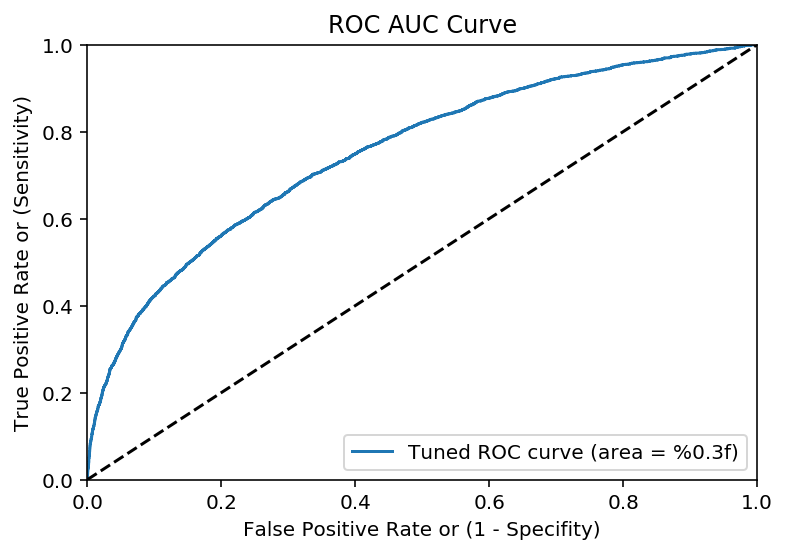

In [206]:
#plot for tuned model

y_score = clf_best.predict_proba(X_test)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test,  y_score[:,1])

# # Plot ROC curve
# plt.plot(fpr_base, tpr_base, label='Base ROC curve (area = %0.3f)' % auc_score_base)
plt.plot(fpr_tuned, tpr_tuned, label='Tuned ROC curve (area = %0.3f)')# % auc_score_tuned)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()